In [1]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [80]:
def plot_loss(history, label = 'loss'):
  plt.plot(history.history['loss'], label=label)
  # plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


In [9]:
def generate_polynomial_trajectory(p1, p2, grade=6, n_points=100):
    x = np.linspace(p1[0], p2[0], n_points)
    y = (x - p1[0]) ** grade * (p2[1] - p1[1]) / ((p2[0] - p1[0]) ** grade) + p1[1]
    return np.array(list(zip(x, y)))

def generate_radical_trajectory(p1, p2, grade=5, n_points=100):
    x = np.linspace(p1[0], p2[0], n_points)
    y = (x - p1[0]) ** (1/grade) * (p2[1] - p1[1]) / ((p2[0] - p1[0]) ** (1 / grade)) + p1[1]
    return np.array(list(zip(x, y)), dtype=np.float32)

def generate_linear_trajectory(p1, p2, n_points=100):
    x = np.linspace(p1[0], p2[0], n_points)
    y = (x - p1[0]) * (p2[1] - p1[1]) / (p2[0] - p1[0]) + p1[1]
    return np.array(list(zip(x, y)), dtype=np.float32)

## Data Loading

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving X_TWO_JOINTS.csv to X_TWO_JOINTS.csv
Saving Y_TWO_JOINTS.csv to Y_TWO_JOINTS.csv
User uploaded file "X_TWO_JOINTS.csv" with length 1527798 bytes
User uploaded file "Y_TWO_JOINTS.csv" with length 516435 bytes


In [5]:
df_X = pd.read_csv('X_TWO_JOINTS.csv', header= None, usecols=[0,2], names=["X","Z"])
df_Y = pd.read_csv('Y_TWO_JOINTS.csv', header= None, names=["J1","J3"])
df_data = df_X.join(df_Y)
print(df_data)

             X         Z         J1          J3
0     0.182892  1.103669  -2.659524  -16.910634
1    -0.018991  0.840641 -78.769963 -115.164880
2    -0.786893  0.568495 -91.302315  -18.153684
3     0.350853  0.842898 -24.786045  -88.304229
4     0.014872  1.059766 -41.132881  -61.260355
...        ...       ...        ...         ...
9995  0.636020  0.261123  40.104177  -80.381565
9996  0.637171  0.307646  35.712157  -80.978438
9997  0.210339  1.076435 -12.282699  -37.298402
9998 -0.560832  0.924573 -54.132491   -7.120594
9999  0.235456  0.049541  40.037619 -137.748416

[10000 rows x 4 columns]


In [60]:
train, test = train_test_split(df_data,test_size=0.3)
X_train , X_test = train[["X", "Z"]], test[["X", "Z"]]
Y_train , Y_test = train[["J1", "J3"]], test[["J1", "J3"]]
print(Y_train)

             J1          J3
2592 -30.286358 -103.157349
243  -25.967539  -19.052528
2770  24.713639  -70.477906
9683  26.517846   -4.088792
1271 -11.615579  -77.233588
...         ...         ...
5681 -83.564581 -114.615837
9338  12.085336 -136.815230
5537   7.671329  -69.984368
2016 -73.101482  -67.300276
4316  24.300095  -57.909496

[7000 rows x 2 columns]


## Plot Data & Test Trajectories

### Trajectory 1

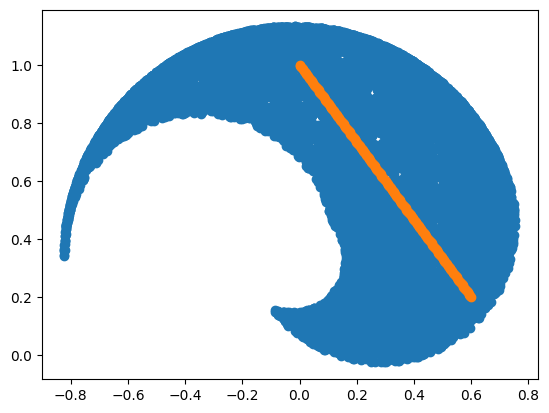

In [25]:
plt.scatter(df_data['X'], df_data['Z'])
p1 , p2 = [0.0,1.0] , [0.6, 0.2]
trajectory_1 = generate_linear_trajectory(p1,p2,200)
plt.scatter(trajectory_1[:,0], trajectory_1[:,1])

### Trajectory 2

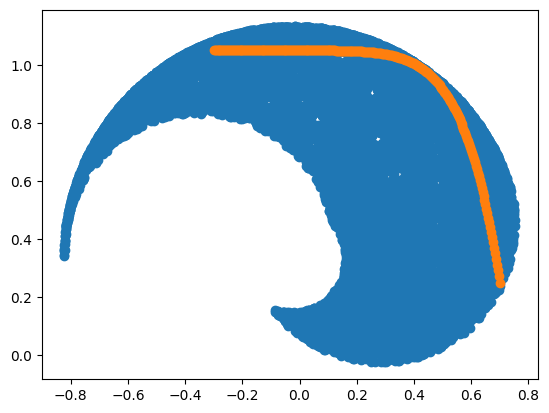

In [59]:
plt.scatter(df_data['X'], df_data['Z'])
p1 , p2 = [-0.3,1.05] , [0.7, 0.25]
trajectory_2 = generate_polynomial_trajectory(p1,p2,8,300)
plt.scatter(trajectory_2[:,0], trajectory_2[:,1])

### Trajectory 3

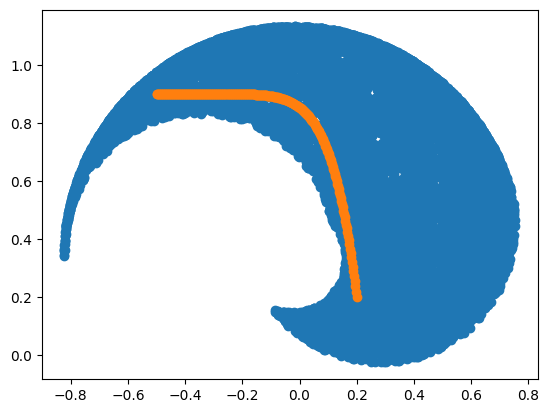

In [50]:
plt.scatter(df_data['X'], df_data['Z'])
p1 , p2 = [-0.5,0.9], [0.2, 0.2]
trajectory_3 = generate_polynomial_trajectory(p1,p2,8,300)
plt.scatter(trajectory_3[:,0], trajectory_3[:,1])

## Model Training

### Hyperparameters

In [61]:
activation = 'sigmoid'
learning_rate = 0.001
loss = 'mean_absolute_error'
n_hidden_neurons = 64
epochs = 100

### Model 1

In [93]:
model_inverse_1 = keras.Sequential([
    InputLayer(input_shape=(X_train.shape[1])),
    Dense(n_hidden_neurons, activation=activation),
    Dense(n_hidden_neurons, activation=activation),
    Dense(n_hidden_neurons, activation=activation),
    Dense(2)
], name="model_inverse_1")

model_inverse_1.compile(loss=loss,
              optimizer=keras.optimizers.Adam(learning_rate))


In [94]:
model_inverse_1.summary()

Model: "model_inverse_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                192       
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 2)                 130       
                                                                 
Total params: 8,642
Trainable params: 8,642
Non-trainable params: 0
_________________________________________________________________


### Model 2

In [95]:
model_inverse_2 = keras.Sequential([
    InputLayer(input_shape=(X_train.shape[1])),
    Dense(n_hidden_neurons*4, activation=activation),
    Dense(n_hidden_neurons*2, activation=activation),
    Dense(n_hidden_neurons, activation=activation),
    Dense(2)
], name="model_inverse_2")

model_inverse_2.compile(loss=loss,
              optimizer=keras.optimizers.Adam(learning_rate))

In [96]:
model_inverse_2.summary()

Model: "model_inverse_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               768       
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 2)                 130       
                                                                 
Total params: 42,050
Trainable params: 42,050
Non-trainable params: 0
_________________________________________________________________


### Model 3

In [113]:
model_inverse_3 = keras.Sequential([
    InputLayer(input_shape=(X_train.shape[1])),
    Dense(n_hidden_neurons*4, activation=activation),
    Dense(n_hidden_neurons*4, activation=activation),
    Dense(n_hidden_neurons*4, activation=activation),
    Dense(2)
], name="model_inverse_3")

model_inverse_3.compile(loss=loss,
              optimizer=keras.optimizers.Adam(learning_rate))

In [114]:
model_inverse_3.summary()

Model: "model_inverse_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               768       
                                                                 
 dense_29 (Dense)            (None, 256)               65792     
                                                                 
 dense_30 (Dense)            (None, 256)               65792     
                                                                 
 dense_31 (Dense)            (None, 2)                 514       
                                                                 
Total params: 132,866
Trainable params: 132,866
Non-trainable params: 0
_________________________________________________________________


### Training

In [99]:
history_1 = model_inverse_1.fit(
    X_train,
    Y_train,
    epochs=epochs
)

Epoch 1/100
219/219 [==============================] - 1s 1ms/step - loss: 62.2091
Epoch 2/100
219/219 [==============================] - 0s 1ms/step - loss: 57.1517
Epoch 3/100
219/219 [==============================] - 0s 1ms/step - loss: 53.5515
Epoch 4/100
219/219 [==============================] - 0s 1ms/step - loss: 50.6865
Epoch 5/100
219/219 [==============================] - 0s 1ms/step - loss: 48.3278
Epoch 6/100
219/219 [==============================] - 0s 1ms/step - loss: 46.4600
Epoch 7/100
219/219 [==============================] - 0s 1ms/step - loss: 44.9430
Epoch 8/100
219/219 [==============================] - 0s 1ms/step - loss: 43.8149
Epoch 9/100
219/219 [==============================] - 0s 1ms/step - loss: 42.9497
Epoch 10/100
219/219 [==============================] - 0s 1ms/step - loss: 42.2969
Epoch 11/100
219/219 [==============================] - 0s 1ms/step - loss: 41.8448
Epoch 12/100
219/219 [==============================] - 0s 1ms/step - loss: 41.5447
E

In [100]:
history_2 = model_inverse_2.fit(
    X_train,
    Y_train,
    epochs=epochs
)

Epoch 1/100
219/219 [==============================] - 1s 1ms/step - loss: 61.5250
Epoch 2/100
219/219 [==============================] - 0s 1ms/step - loss: 56.5004
Epoch 3/100
219/219 [==============================] - 0s 1ms/step - loss: 52.7075
Epoch 4/100
219/219 [==============================] - 0s 1ms/step - loss: 49.7310
Epoch 5/100
219/219 [==============================] - 0s 1ms/step - loss: 47.4289
Epoch 6/100
219/219 [==============================] - 0s 1ms/step - loss: 45.6795
Epoch 7/100
219/219 [==============================] - 0s 1ms/step - loss: 44.3384
Epoch 8/100
219/219 [==============================] - 0s 1ms/step - loss: 43.3148
Epoch 9/100
219/219 [==============================] - 0s 1ms/step - loss: 42.5452
Epoch 10/100
219/219 [==============================] - 0s 1ms/step - loss: 41.9889
Epoch 11/100
219/219 [==============================] - 0s 1ms/step - loss: 41.6252
Epoch 12/100
219/219 [==============================] - 0s 1ms/step - loss: 41.3870
E

In [115]:
history_3 = model_inverse_3.fit(
    X_train,
    Y_train,
    epochs=epochs
)

Epoch 1/100
219/219 [==============================] - 1s 3ms/step - loss: 54.6794
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 45.7073
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 42.3436
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 41.3159
Epoch 5/100
219/219 [==============================] - 1s 3ms/step - loss: 41.0942
Epoch 6/100
219/219 [==============================] - 1s 4ms/step - loss: 41.0571
Epoch 7/100
219/219 [==============================] - 1s 4ms/step - loss: 41.0509
Epoch 8/100
219/219 [==============================] - 1s 3ms/step - loss: 41.0535
Epoch 9/100
219/219 [==============================] - 1s 3ms/step - loss: 41.0517
Epoch 10/100
219/219 [==============================] - 1s 3ms/step - loss: 41.0537
Epoch 11/100
219/219 [==============================] - 1s 3ms/step - loss: 41.0524
Epoch 12/100
219/219 [==============================] - 1s 3ms/step - loss: 41.0512
E

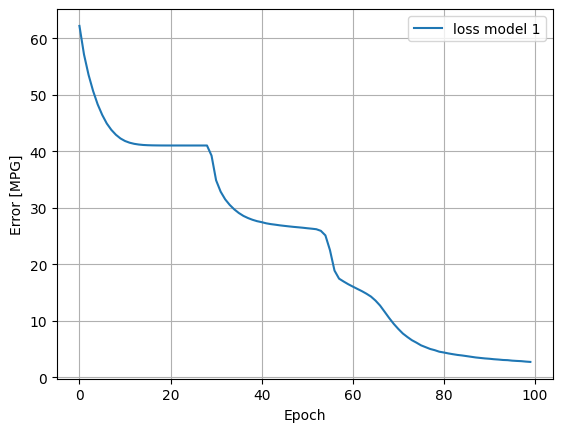

In [105]:
plot_loss(history_1,"loss model 1")

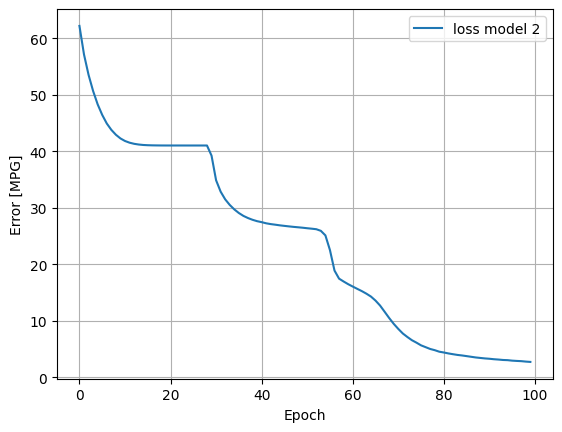

In [104]:
plot_loss(history_1,"loss model 2")

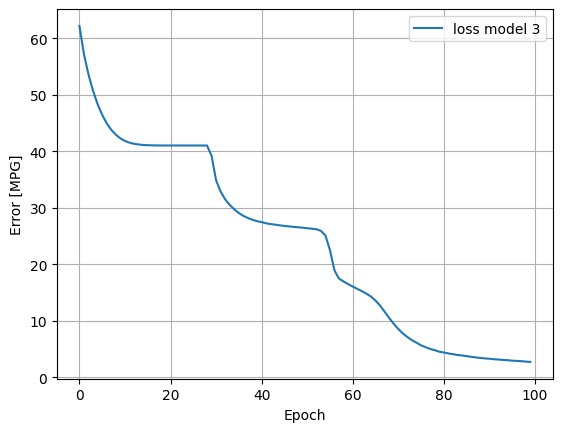

In [106]:
plot_loss(history_1,"loss model 3")

In [107]:
results_1 = model_inverse_1.evaluate(
    X_test,
    Y_test, 
    verbose=0
)
results_1

2.916064500808716

In [110]:
results_2 = model_inverse_2.evaluate(
    X_test,
    Y_test, 
    verbose=0
)
results_2

2.0165469646453857

In [111]:
results_3 = model_inverse_3.evaluate(
    X_test,
    Y_test, 
    verbose=0
)
results_3

2.7172906398773193

In [112]:
model_inverse_1.save('model_inverse_1.h5')
model_inverse_1.save('model_inverse_2.h5')
model_inverse_1.save('model_inverse_3.h5')

In [ ]:
# loaded_model = keras.models.load_model("model_inverse_2joints_64hl.h5")
# loaded_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                192       
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 2)                 130       
                                                                 
Total params: 4,482
Trainable params: 4,482
Non-trainable params: 0
_________________________________________________________________
